In [17]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import gaussian_kde
import seaborn as sns
from joblib import Parallel, delayed
from IPython.display import clear_output

import warnings

warnings.filterwarnings('ignore')


1. RateConst Reader


In [18]:
def getAllRateInfo(file):   
    res=pd.DataFrame()
    try:
        temp=pd.read_csv(file)
        temp=temp.dropna()
        temp['Protein']=file.split('\\')[-1].replace('.RateConst.csv','')
        res=pd.concat([res,temp])
    except Exception as exp:
        return res
    
    return res
def getAllRate(data_path):
    results = Parallel(n_jobs=-1)(delayed(getAllRateInfo)(file) for file in [os.path.join(data_path,x) for x in os.listdir(data_path) if '.RateConst.csv' in x  ]) 
    all_data=pd.concat(results)
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

2. Quant File Reader

In [19]:
def read_n_merge(skip,file):
    file_data=pd.read_csv(file,skiprows=skip,index_col=False)
    file_data.columns=[x.strip() for x in file_data.columns]
    isparsed=(set(['Peptide', 'UniqueToProtein', 'Exchangeable Hydrogens', 'Charge',
       'm/z(Sequence)', 'M0', 'M1', 'M2', 'M3', 'M4']).issubset(set(file_data.columns)))
    isparsed=isparsed and file_data.shape[0]>0    
    if isparsed:
        file_data['Protein']=file.split('\\')[-1].replace('.Quant.csv','') 
        return [isparsed,file_data]
    else:
        return [isparsed,None]
def get_df_all_quant_files(file):
    res=read_n_merge(1,file)
    all_data=None
    if res[0]: all_data=res[1]
    else: all_data=read_n_merge(3,file)[1]
    return all_data

def getquantfile(data_path):
    results = Parallel(n_jobs=-1)(delayed(get_df_all_quant_files)(file) for file in [os.path.join(data_path,x) for x in os.listdir(data_path) if '.Quant.csv' in x  ])
    all_data=pd.concat(results)
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

3. Data source & path

In [20]:
organ="liver"
# organ="heart"
# organ="muscle"
data_path=r'C:\Workplace\Python\AnalysisForThePaper\NEH\d2ome_output\liverpool_liver'
# data_path=r'C:\Workplace\Python\AnalysisForThePaper\NEH\d2ome_output\liverpool_heart'
# data_path=r'H:\Warehouse\Data\DataUsedForPublication\Partial IsotopeProfile paper data used for publication\liverpool_CI\muscle'


data_quant=getquantfile(data_path)
data_rate=getAllRate(data_path)
data_rate=data_rate[(data_rate.Rsquared!=' -nan(ind)')&(data_rate.Rsquared!=' ')]



4. merge quant and rate files

In [21]:
merged=pd.merge(data_quant,
                data_rate,
                left_on=['Protein','Peptide','Charge'],
                right_on=['Protein','Peptides','Charge'])
merged=merged.reset_index(drop=True)
merged.shape

(18510, 219)

5. parameters

In [22]:
pw,ph=0.046,1.5574E-4
# rsquared= 0.99
maxrate=math.log(2)
exp_time=[0 ,1 ,2 ,3 ,6 ,7 ,9 ,13,16,21,24,31]

6. filter data

In [23]:
merged=merged[#(merged.Rsquared.astype('float')>=rsquared) &
              (merged.RateConstants< math.log(2))]
merged=merged.reset_index(drop=True)
merged.shape

(17344, 219)

7. Helper functions

In [24]:
def get_I0_t(I0_0,I0_asymp,k,t):
    return I0_asymp + (I0_0-I0_asymp)*math.exp(-k*t)

def get_I0_asmyp(I0_0,neh):
    return I0_0*( (1 - pw/(1-ph))**neh )

def get_I0_exp(index,suffix):
    _sum=float(float(merged.loc[index,f'I0{suffix}'])+float(merged.loc[index,f'I1{suffix}'])+float(merged.loc[index,f'I2{suffix}'])+float(merged.loc[index,f'I3{suffix}'])+
                        float(merged.loc[index,f'I4{suffix}'])+float(merged.loc[index,f'I5{suffix}']))
    if _sum==0: return None
    else: return float(merged.loc[index,f'I0{suffix}'])/_sum

def getNewKestimate(M0_0,I0_0_exp,I0_asymp,t,I0_t_exp,numberofTerms): 
        
    base=(I0_0_exp-I0_t_exp)/(M0_0-I0_asymp)    
    new_kt= sum([ (base**i)/i for i in range(1,numberofTerms+1)])     
    new_k=new_kt/t    
    return new_k


def getNewKestimateByIndex(time,numberofterms_1,index,numberofterms_10):
        
        time_index=exp_time.index(time)
        suffix=f".{time_index}"  
        # print('time',time,time_index)
                                              
        if merged.loc[index,f'I0{suffix}'] == ' ' or merged.loc[index,f'I0'] == ' ': 
            return None            
        
        I0_0_exp= get_I0_exp(index,"")
        I0_t_exp=get_I0_exp(index,suffix)
        
        if I0_0_exp == None or I0_t_exp ==None or  I0_t_exp >  I0_0_exp: 
            return None

        M0_0=float(merged.loc[index,f'M0'])/100
        k=float(merged.loc[index,f'RateConstants'])
        I0_asymp=M0_0*( (1 - pw/(1-ph))**merged.loc[index,f'Exchangeable Hydrogens'] ) 
        i0_t_theo= I0_asymp + (M0_0-I0_asymp)*math.exp(-k*time)     
        
        exp_fsr= (I0_0_exp-I0_t_exp)/(M0_0-I0_asymp)
        # print(exp_fsr, (I0_0_exp-I0_t_exp),(M0_0-I0_asymp),"==>",(I0_0_exp,I0_t_exp),(M0_0,I0_asymp) )
        if exp_fsr > 1: return None
        exp_kt= -math.log( 1 - exp_fsr) 
        d2ome_kt=k*time
        
        error=   abs(exp_kt - d2ome_kt)/d2ome_kt
        
        

        return[merged.loc[index,'Protein'],
               merged.loc[index,'Peptide'],
               merged.loc[index,'Charge'],                
                merged.loc[index,f'Exchangeable Hydrogens'],
                M0_0,I0_0_exp,
                I0_asymp,
                I0_t_exp,i0_t_theo,k,exp_kt/time] +[getNewKestimate(M0_0,I0_0_exp,I0_asymp,time,I0_t_exp,numberofterms_1),
                                                    getNewKestimate(M0_0,I0_0_exp,I0_asymp,time,I0_t_exp,numberofterms_10),error]
        
def computeAllNewRates(_time,_numberOfTerms,_numberOfTerms10):
    # res = Parallel(n_jobs=-1)(delayed(getNewKestimateByIndex)(_time,_numberOfTerms,index) for index in range(merged.shape[0]))
    res=[getNewKestimateByIndex(_time,_numberOfTerms,index,_numberOfTerms10) for index in range(merged.shape[0])]
    res=pd.DataFrame([r for r in res if r!=None])
    res.columns=['Protein','Peptide','Charge',"NEH","M0","I0_0_exp","I0_asmp",'i0_t_exp','i0_t_theo','d2ome_k','k_sol','new_k_1','new_k_10','error']
    return res

def plot_hitmap(x,y,time,path="",title=""):
          
    plt.rc('font',size=14)
    plt.figure(figsize=(7,6))
    plt.set_cmap('jet')  
    
    x=np.array(x)
    y=np.array(y)    
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    r=np.corrcoef(x,y)
    
    # Create the main plot
    _, ax1 = plt.subplots()


    cb=ax1.scatter(x, y, c=z, s=10,alpha=0.8)  
    ax1.plot(x,x,ls='-.',c='k',linewidth=1,alpha=0.5,label=f"n={len(list(x))}\nr={int(1000*r[0][1])/1000}")      
    cbar = plt.colorbar(cb)
    ax1.set_ylabel("k (Single time point)"+ r"$, day^{-1}$")
    ax1.set_xlabel("k (Time course data)" + r"$, day^{-1}$")    
    ax1.legend()  
    # Remove top and right spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    # ax1.set_xlim([0,min(max(x),0.3)])
    # ax1.set_ylim([0,min(max(y),0.3)])
    
    ax1.set_xlim([0,max(x)])
    ax1.set_ylim([0,max(y)])
    
    
    ax1.set_xlim([0, min(max(x),math.log(2))])
    ax1.set_ylim([0, min(max(y),math.log(2))])
    
    
    # # Create the second x-axis
    # ax2 = ax1.twiny()
    # ax2.set_xlim(ax1.get_xlim())
    # ax2.set_xticks([(i*time) for i in ax1.get_xticks()])
    # ax2.set_xlabel('kt', color='k')
    # ax2.spines['right'].set_visible(False)
    # ax2.set_xlim([0,min(max(ax2.get_xticks()),0.3)])
    # ax2.set_ylim([0,min(max(ax2.get_yticks()),0.3)])

    # Adjust layout to prevent labels from overlapping
    plt.tight_layout()
    plt.ylim([0,1.2])
    if len(path)>0:
        plt.savefig(f"{path}/{title}.jpeg",dpi=900)
        
    plt.show()
    
    
   
def plotRateRDDensity(x,y,path="",title=""):
    plt.rc('font',size=14)
    plt.figure(figsize=(8,6)) 
    rd_k= (x - y)/x
    ax=sns.histplot(rd_k, kde=True, #bins=50,
                label=f"n={len(rd_k)},μ = {int(100*np.mean(rd_k))/100}, \nmedian = {int(100*np.median(rd_k))/100}, \nsd = {int(100*np.std(rd_k))/100}",
                color='white',alpha=0.1,edgecolor=('black',0.75) )
    ax.lines[0].set_color('k')
    ax.lines[0].set_alpha(0.75) 
    ax.lines[0].set_ls(':') 
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel(r'$\frac{ k _{\:Time\: course\: data} - k _{\:Single\: time\: point}}{k _{\:Time\: course\: data}}$')
    plt.legend()
    plt.tight_layout()
    if len(path)>0:
        plt.savefig(f"{path}/{title}_RD_k.jpeg",dpi=900)
    plt.show()

8. Prepare all new k values

In [25]:
allmerged=merged.copy()
allmerged.shape

(17344, 219)

In [26]:
# for _time in tqdm([1 ,2 ,3 ,6 ,7,13,16]):
# # for _time in tqdm([6 ,7,16]):    
#     for _rsquared in [0.99,0.95,0.9][::-1]:
                        
#             try:                
#                 merged=allmerged.copy()
#                 merged=merged[(merged.Rsquared.astype('float')>=_rsquared)]
#                 merged=merged.reset_index(drop=True)


#                 res=computeAllNewRates(_time,1,10)

#                 res=res[(res.d2ome_k.astype('float')>=0)]
#                 res=res[(res.new_k_1.astype('float')>=0)]
#                 res=res[(res.new_k_10.astype('float')>=0)]
#                 res=res[(res.k_sol.astype('float')>=0)]

#                 res=res[abs(res.M0 -res.I0_0_exp)/res.M0 <=0.1]
                
                
#                 _title=f"{organ}_day_{_time}_fsr"   
#                 _path1=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/"
#                 if not os.path.exists(_path1): os.makedirs(_path1)
#                 res.to_csv(_path1+_title+".csv",index=False)

#                 #============================ FSR ===============================
#                 #============================ === ===============================            
#                 _res=res.copy()
#                 _path1=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/fsr/"
#                 if not os.path.exists(_path1): os.makedirs(_path1)

#                 _title=f"{organ}_day_{_time}_fsr"    

#                 plot_hitmap(_res.d2ome_k,_res.k_sol,_time,_path1,_title+"_all")
#                 plotRateRDDensity(_res.d2ome_k,_res.k_sol,_path1,_title+"_Density_all")


#                 # #filtered============================================
#                 # _res=_res[_res.i0_t_exp < _res.I0_0_exp- 0.04*_res.I0_0_exp]
#                 # _res=_res[_res.i0_t_exp > _res.I0_0_exp - 0.5*(_res.i0_t_theo - _res.I0_asmp)]

#                 # try:
#                 #     plot_hitmap(_res.d2ome_k,_res.k_sol,_time,_path1,_title+"_filtered")
#                 #     plotRateRDDensity(_res.d2ome_k,_res.k_sol,_path1,_title+"_Density_filtered")
#                 # except: continue

#                 clear_output(wait=True)  
#                 #============================ 1-TERM ============================
#                 #============================ === ===============================            
#                 _res=res.copy()

#                 _path1=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/numberofterms_{1}/"
#                 if not os.path.exists(_path1): os.makedirs(_path1)

#                 _title=f"{organ}_day_{_time}_numberofterms_{1}"    

#                 plot_hitmap(_res.d2ome_k,_res.new_k_1,_time,_path1,_title+"_all")
#                 plotRateRDDensity(_res.d2ome_k,_res.new_k_1,_path1,_title+"_Density_all")


#                 # #filtered============================================
#                 # _res=_res[_res.i0_t_exp < _res.I0_0_exp- 0.04*_res.I0_0_exp]
#                 # _res=_res[_res.i0_t_exp > _res.I0_0_exp - 0.5*(_res.i0_t_theo - _res.I0_asmp)] 

#                 # try:
#                 #     plot_hitmap(_res.d2ome_k,_res.new_k_1,_time,_path1,_title+"_filtered")
#                 #     plotRateRDDensity(_res.d2ome_k,_res.new_k_1,_path1,_title+"_Density_filtered")
#                 # except: continue

#                 # clear_output(wait=True)  
#                 #============================ 10-TERM ===========================
#                 #============================ === ===============================            
#                 _res=res.copy()

#                 _path1=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/numberofterms_{10}/"
#                 if not os.path.exists(_path1): os.makedirs(_path1)

#                 _title=f"{organ}_day_{_time}_numberofterms_{10}"    

#                 plot_hitmap(_res.d2ome_k,_res.new_k_10,_time,_path1,_title+"_all")
#                 plotRateRDDensity(_res.d2ome_k,_res.new_k_10,_path1,_title+"_Density_all")


#                 # #filtered============================================
#                 # _res=_res[_res.i0_t_exp < _res.I0_0_exp- 0.04*_res.I0_0_exp]
#                 # _res=_res[_res.i0_t_exp > _res.I0_0_exp - 0.5*(_res.i0_t_theo - _res.I0_asmp)]

#                 # try:
#                 #     plot_hitmap(_res.d2ome_k,_res.new_k_10,_time,_path1,_title+"_filtered")
#                 #     plotRateRDDensity(_res.d2ome_k,_res.new_k_10,_path1,_title+"_Density_filtered")
#                 # except: continue

#                 clear_output(wait=True)  

 
#             except Exception as exp:
#                 print(exp)
#                 continue


<Figure size 700x600 with 0 Axes>

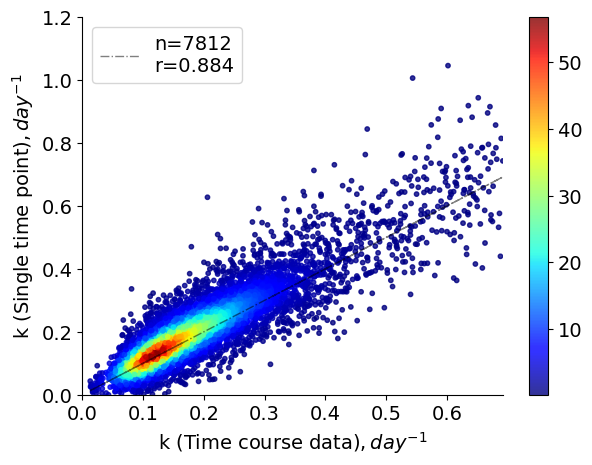

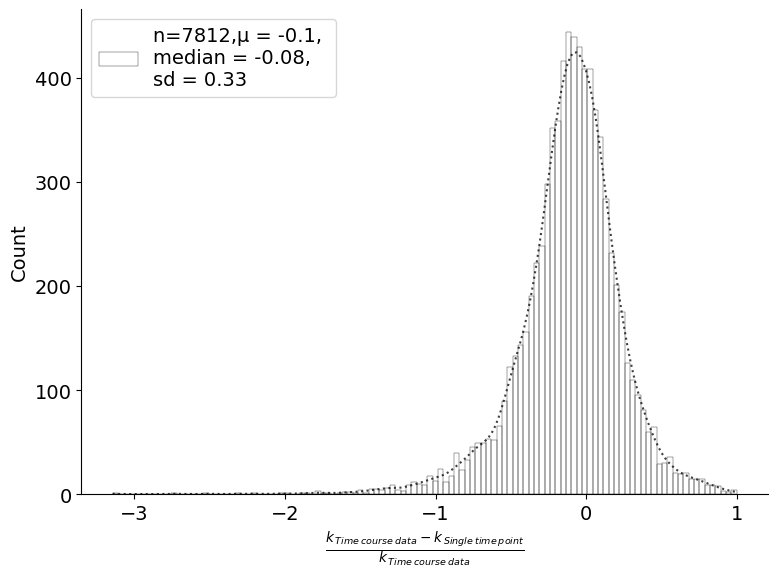

<Figure size 700x600 with 0 Axes>

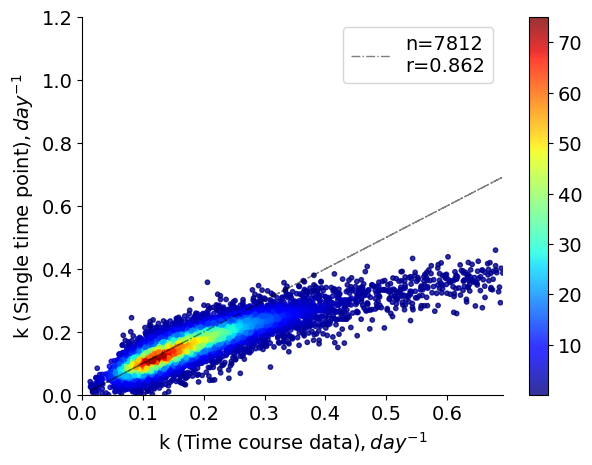

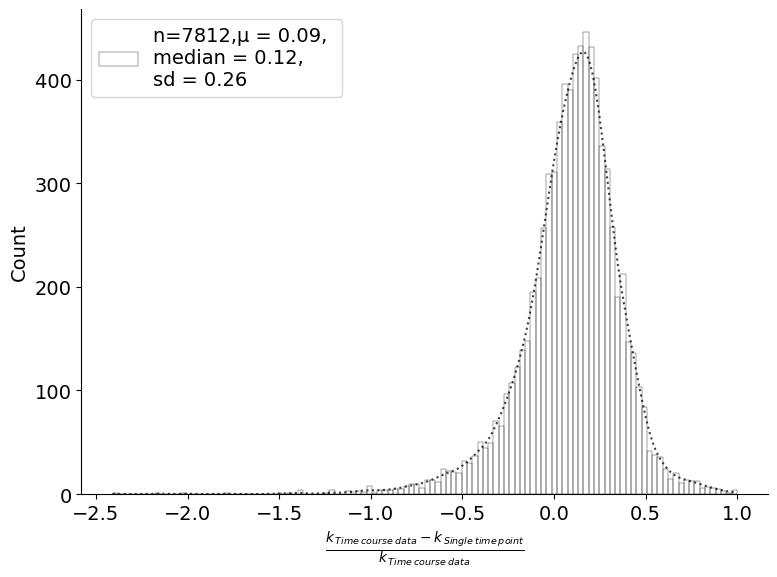

In [30]:
# for _time in tqdm([1 ,2 ,3 ,6 ,7,13,16]):
# # for _time in tqdm([6 ,7,16]):    
#     for _rsquared in [0.99,0.95,0.9][::-1]:

_time = 2
_rsquared= 0.9
            
try:                
    merged=allmerged.copy()
    merged=merged[(merged.Rsquared.astype('float')>=_rsquared)]
    merged=merged.reset_index(drop=True)


    res=computeAllNewRates(_time,1,10)

    res=res[(res.d2ome_k.astype('float')>=0)]
    res=res[(res.new_k_1.astype('float')>=0)]
    res=res[(res.new_k_10.astype('float')>=0)]
    res=res[(res.k_sol.astype('float')>=0)]

    res=res[abs(res.M0 -res.I0_0_exp)/res.M0 <=0.1]
    
    
    _title=f"{organ}_day_{_time}_fsr"   
    _path1=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/"
    if not os.path.exists(_path1): os.makedirs(_path1)
    # res.to_csv(_path1+_title+".csv",index=False)

    #============================ FSR ===============================
    #============================ === ===============================            
    _res=res.copy()
    _path1=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/fsr/"
    if not os.path.exists(_path1): os.makedirs(_path1)

    _title=f"{organ}_day_{_time}_fsr"    

    plot_hitmap(_res.d2ome_k,_res.k_sol,_time,_path1,_title+"_all")
    plotRateRDDensity(_res.d2ome_k,_res.k_sol,_path1,_title+"_Density_all")
 

    # clear_output(wait=True)  
    #============================ 1-TERM ============================
    #============================ === ===============================            
    _res=res.copy()

    _path1=f"Figures/{organ}/Day_{_time}/r2_{_rsquared}/numberofterms_{1}/"
    if not os.path.exists(_path1): os.makedirs(_path1)

    _title=f"{organ}_day_{_time}_numberofterms_{1}"    

    plot_hitmap(_res.d2ome_k,_res.new_k_1,_time,_path1,_title+"_all")
    plotRateRDDensity(_res.d2ome_k,_res.new_k_1,_path1,_title+"_Density_all")

 


except Exception as exp:
    print(exp)    


In [28]:
_res['rd']= abs(_res.d2ome_k-_res.k_sol) /_res.d2ome_k
_res

,Protein,Peptide,Charge,NEH,M0,I0_0_exp,I0_asmp,i0_t_exp,i0_t_theo,d2ome_k,k_sol,new_k_1,new_k_10,error,rd
0,1433B_MOUSE,NLLSVAYK,2,11,0.58030,0.606359,0.345660,0.551337,0.544429,0.16591,0.267215,0.234492,0.267215,0.610603,0.610603
1,1433B_MOUSE,EMQPTHPIR,3,21,0.50917,0.540605,0.189370,0.476429,0.468335,0.13661,0.223986,0.200674,0.223986,0.639604,0.639604
2,1433B_MOUSE,DSTLIMQLLR,2,16,0.48532,0.501686,0.228428,0.455853,0.439584,0.19606,0.196520,0.178415,0.196520,0.002347,0.002347
3,1433B_MOUSE,YLSEVASGENK,2,23,0.50852,0.508958,0.172126,0.440122,0.436634,0.24041,0.228947,0.204629,0.228947,0.047680,0.047680
4,1433B_MOUSE,YLILNATQAESK,2,23,0.45538,0.476632,0.154139,0.389260,0.384224,0.26946,0.342545,0.290039,0.342545,0.271229,0.271229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8706,XYLB_MOUSE,IRDESAScSWNK,3,26,0.44218,0.471699,0.129949,0.384834,0.396166,0.15943,0.326017,0.278207,0.326017,1.044891,1.044891
8707,YBOX1_MOUSE,NYQQNYQNSESGEK,2,34,0.39432,0.410780,0.079503,0.294176,0.305242,0.33261,0.462650,0.370387,0.462647,0.390967,0.390967
8708,YBOX1_MOUSE,GAEAANVTGPGGVPVQGSK,2,42,0.38595,0.404305,0.053386,0.313361,0.303774,0.28382,0.319464,0.273462,0.319464,0.125587,0.125587
8709,ZO1_MOUSE,EEAVLFLLDLPK,2,20,0.42956,0.449484,0.167466,0.371541,0.343084,0.40039,0.352943,0.297383,0.352943,0.118503,0.118503


In [29]:
_res[_res['rd']<=0.3].shape[0]/_res.shape[0]

0.5295035092279698